3. Завдання щодо генерації або стилізації зображень (на вибір) <br>
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion). <br>
Датасети: можна брати CIFAR-100, Fashion MNIST або тут: https://www.kaggle.com/tags/image-data <br>
Приклади: <br>
https://github.com/natsakh/Data-Analysis/tree/main/Pr_9 <br>
https://keras.io/examples/generative/neural_style_transfer/ <br>
https://keras.io/examples/generative/ddim/

Використовую MNIST FASHION датасет

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm


In [ ]:

# Ensure reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Hyperparameters
BATCH_SIZE = 128
NOISE_DIM = 100
EPOCHS = 50  # You can adjust this as needed
BUFFER_SIZE = 60000
IMAGE_SHAPE = (28, 28, 1)
CHECKPOINT_EVERY = 10  # Save checkpoint every 10 epochs

# Create directories for saving outputs
os.makedirs('generated_images', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Load Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
test_images = (test_images.astype('float32') - 127.5) / 127.5

# Expand dimensions to add channel axis
train_images = np.expand_dims(train_images, axis=-1)  # Shape: (60000, 28, 28, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Shape: (10000, 28, 28, 1)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)


In [ ]:

# Generator Model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))  # Shape: (7, 7, 256)

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))
    # Output shape: (28, 28, 1)

    return model


In [ ]:

# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=IMAGE_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Output: Real or Fake

    return model


In [ ]:

# Instantiate models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Try to label fake as real

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Checkpointing
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:

# Seed for generating images
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Generate images from the seed
    predictions = model(test_input, training=False)

    # Rescale images from [-1,1] to [0,1]
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)


In [ ]:

# Function to evaluate discriminator on test dataset
def evaluate_discriminator(model, test_dataset):
    real_labels = []
    fake_labels = []
    real_preds = []
    fake_preds = []

    for test_batch in test_dataset:
        real_output = model(test_batch, training=False)
        real_preds.extend(real_output.numpy())
        real_labels.extend([1] * test_batch.shape[0])

        # Generate fake images
        noise = tf.random.normal([test_batch.shape[0], NOISE_DIM])
        fake_images = generator(noise, training=False)
        fake_output = model(fake_images, training=False)
        fake_preds.extend(fake_output.numpy())
        fake_labels.extend([0] * test_batch.shape[0])

    # Combine and compute metrics
    all_preds = np.array(real_preds + fake_preds).flatten()
    all_labels = np.array(real_labels + fake_labels)

    # Compute accuracy
    predictions_binary = (all_preds > 0.5).astype(int)
    accuracy = np.mean(predictions_binary == all_labels)

    # Compute loss
    loss = cross_entropy(all_labels, all_preds).numpy()

    return loss, accuracy


In [ ]:

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:

# Training loop
def train(train_dataset, test_dataset, epochs):
    for epoch in range(1, epochs + 1):
        gen_loss_avg = 0.0
        disc_loss_avg = 0.0
        num_batches = 0

        # Progress bar for the current epoch
        with tqdm(total=len(train_dataset), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
            for image_batch in train_dataset:
                gen_loss, disc_loss = train_step(image_batch)
                gen_loss_avg += gen_loss.numpy()
                disc_loss_avg += disc_loss.numpy()
                num_batches += 1
                pbar.update(1)

        # Average losses
        gen_loss_avg /= num_batches
        disc_loss_avg /= num_batches

        # Generate and save images
        generate_and_save_images(generator, epoch, seed)

        # Evaluate discriminator on test dataset
        disc_test_loss, disc_test_acc = evaluate_discriminator(discriminator, test_dataset)

        # Print epoch summary
        print(f"Epoch {epoch}/{epochs} - Gen Loss: {gen_loss_avg:.4f}, Disc Loss: {disc_loss_avg:.4f}, "
              f"Disc Test Loss: {disc_test_loss:.4f}, Disc Test Acc: {disc_test_acc:.4f}")

        # Save checkpoints at specified intervals
        if epoch % CHECKPOINT_EVERY == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch}.")

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)


In [10]:

# Start training
train(train_dataset, test_dataset, EPOCHS)


Epoch 1/50: 100%|██████████| 469/469 [00:20<00:00, 22.78batch/s]


Epoch 1/50 - Gen Loss: 0.8512, Disc Loss: 1.1682, Disc Test Loss: 0.3627, Disc Test Acc: 0.8370


Epoch 2/50: 100%|██████████| 469/469 [00:13<00:00, 34.03batch/s]


Epoch 2/50 - Gen Loss: 0.9670, Disc Loss: 1.1805, Disc Test Loss: 0.4718, Disc Test Acc: 0.7557


Epoch 3/50: 100%|██████████| 469/469 [00:13<00:00, 33.93batch/s]


Epoch 3/50 - Gen Loss: 1.0163, Disc Loss: 1.1992, Disc Test Loss: 0.7576, Disc Test Acc: 0.5525


Epoch 4/50: 100%|██████████| 469/469 [00:13<00:00, 34.28batch/s]


Epoch 4/50 - Gen Loss: 0.9767, Disc Loss: 1.1725, Disc Test Loss: 0.6682, Disc Test Acc: 0.6586


Epoch 5/50: 100%|██████████| 469/469 [00:13<00:00, 34.26batch/s]


Epoch 5/50 - Gen Loss: 0.9339, Disc Loss: 1.2442, Disc Test Loss: 0.5692, Disc Test Acc: 0.6375


Epoch 6/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 6/50 - Gen Loss: 0.9853, Disc Loss: 1.1172, Disc Test Loss: 0.4842, Disc Test Acc: 0.7356


Epoch 7/50: 100%|██████████| 469/469 [00:13<00:00, 34.60batch/s]


Epoch 7/50 - Gen Loss: 1.1167, Disc Loss: 1.1514, Disc Test Loss: 0.9898, Disc Test Acc: 0.4474


Epoch 8/50: 100%|██████████| 469/469 [00:13<00:00, 33.92batch/s]


Epoch 8/50 - Gen Loss: 1.0980, Disc Loss: 1.0595, Disc Test Loss: 0.5791, Disc Test Acc: 0.7091


Epoch 9/50: 100%|██████████| 469/469 [00:13<00:00, 34.14batch/s]


Epoch 9/50 - Gen Loss: 1.2180, Disc Loss: 0.9876, Disc Test Loss: 0.6327, Disc Test Acc: 0.6737


Epoch 10/50: 100%|██████████| 469/469 [00:13<00:00, 34.42batch/s]


Epoch 10/50 - Gen Loss: 1.4013, Disc Loss: 0.8826, Disc Test Loss: 0.4455, Disc Test Acc: 0.8095
Checkpoint saved at epoch 10.


Epoch 11/50: 100%|██████████| 469/469 [00:13<00:00, 34.38batch/s]


Epoch 11/50 - Gen Loss: 1.4399, Disc Loss: 0.8723, Disc Test Loss: 0.5952, Disc Test Acc: 0.7127


Epoch 12/50: 100%|██████████| 469/469 [00:13<00:00, 34.63batch/s]


Epoch 12/50 - Gen Loss: 1.5323, Disc Loss: 0.8166, Disc Test Loss: 0.4879, Disc Test Acc: 0.7685


Epoch 13/50: 100%|██████████| 469/469 [00:13<00:00, 34.33batch/s]


Epoch 13/50 - Gen Loss: 1.7498, Disc Loss: 0.7315, Disc Test Loss: 0.2641, Disc Test Acc: 0.8916


Epoch 14/50: 100%|██████████| 469/469 [00:13<00:00, 34.36batch/s]


Epoch 14/50 - Gen Loss: 1.6849, Disc Loss: 0.7887, Disc Test Loss: 0.4199, Disc Test Acc: 0.7968


Epoch 15/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 15/50 - Gen Loss: 1.6104, Disc Loss: 0.8354, Disc Test Loss: 0.3094, Disc Test Acc: 0.8546


Epoch 16/50: 100%|██████████| 469/469 [00:20<00:00, 22.91batch/s]


Epoch 16/50 - Gen Loss: 1.6896, Disc Loss: 0.8096, Disc Test Loss: 0.3181, Disc Test Acc: 0.8721


Epoch 17/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 17/50 - Gen Loss: 1.5443, Disc Loss: 0.8584, Disc Test Loss: 0.3288, Disc Test Acc: 0.8581


Epoch 18/50: 100%|██████████| 469/469 [00:13<00:00, 34.33batch/s]


Epoch 18/50 - Gen Loss: 1.5272, Disc Loss: 0.8932, Disc Test Loss: 0.3660, Disc Test Acc: 0.8286


Epoch 19/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 19/50 - Gen Loss: 1.6042, Disc Loss: 0.8423, Disc Test Loss: 0.4083, Disc Test Acc: 0.8115


Epoch 20/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 20/50 - Gen Loss: 1.4936, Disc Loss: 0.9059, Disc Test Loss: 0.3626, Disc Test Acc: 0.8292
Checkpoint saved at epoch 20.


Epoch 21/50: 100%|██████████| 469/469 [00:13<00:00, 34.32batch/s]


Epoch 21/50 - Gen Loss: 1.4622, Disc Loss: 0.8985, Disc Test Loss: 0.4164, Disc Test Acc: 0.7930


Epoch 22/50: 100%|██████████| 469/469 [00:13<00:00, 33.78batch/s]


Epoch 22/50 - Gen Loss: 1.4547, Disc Loss: 0.9120, Disc Test Loss: 0.3624, Disc Test Acc: 0.8395


Epoch 23/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 23/50 - Gen Loss: 1.4689, Disc Loss: 0.9025, Disc Test Loss: 0.3634, Disc Test Acc: 0.8177


Epoch 24/50: 100%|██████████| 469/469 [00:13<00:00, 34.69batch/s]


Epoch 24/50 - Gen Loss: 1.5265, Disc Loss: 0.8889, Disc Test Loss: 0.3652, Disc Test Acc: 0.8217


Epoch 25/50: 100%|██████████| 469/469 [00:13<00:00, 34.36batch/s]


Epoch 25/50 - Gen Loss: 1.4454, Disc Loss: 0.9365, Disc Test Loss: 0.4035, Disc Test Acc: 0.7940


Epoch 26/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 26/50 - Gen Loss: 1.4612, Disc Loss: 0.9375, Disc Test Loss: 0.4219, Disc Test Acc: 0.8037


Epoch 27/50: 100%|██████████| 469/469 [00:13<00:00, 34.59batch/s]


Epoch 27/50 - Gen Loss: 1.4102, Disc Loss: 0.9599, Disc Test Loss: 0.3226, Disc Test Acc: 0.8380


Epoch 28/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 28/50 - Gen Loss: 1.4520, Disc Loss: 0.9178, Disc Test Loss: 0.3794, Disc Test Acc: 0.8305


Epoch 29/50: 100%|██████████| 469/469 [00:13<00:00, 34.43batch/s]


Epoch 29/50 - Gen Loss: 1.4045, Disc Loss: 0.9524, Disc Test Loss: 0.4088, Disc Test Acc: 0.7915


Epoch 30/50: 100%|██████████| 469/469 [00:13<00:00, 34.11batch/s]


Epoch 30/50 - Gen Loss: 1.3842, Disc Loss: 0.9723, Disc Test Loss: 0.3836, Disc Test Acc: 0.8150
Checkpoint saved at epoch 30.


Epoch 31/50: 100%|██████████| 469/469 [00:13<00:00, 34.38batch/s]


Epoch 31/50 - Gen Loss: 1.3430, Disc Loss: 0.9916, Disc Test Loss: 0.4718, Disc Test Acc: 0.7506


Epoch 32/50: 100%|██████████| 469/469 [00:13<00:00, 34.53batch/s]


Epoch 32/50 - Gen Loss: 1.3645, Disc Loss: 0.9678, Disc Test Loss: 0.4012, Disc Test Acc: 0.8015


Epoch 33/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 33/50 - Gen Loss: 1.2972, Disc Loss: 1.0147, Disc Test Loss: 0.4724, Disc Test Acc: 0.7457


Epoch 34/50: 100%|██████████| 469/469 [00:13<00:00, 34.32batch/s]


Epoch 34/50 - Gen Loss: 1.2869, Disc Loss: 1.0186, Disc Test Loss: 0.3947, Disc Test Acc: 0.8141


Epoch 35/50: 100%|██████████| 469/469 [00:13<00:00, 33.72batch/s]


Epoch 35/50 - Gen Loss: 1.2957, Disc Loss: 1.0158, Disc Test Loss: 0.4733, Disc Test Acc: 0.7390


Epoch 36/50: 100%|██████████| 469/469 [00:13<00:00, 34.20batch/s]


Epoch 36/50 - Gen Loss: 1.2501, Disc Loss: 1.0395, Disc Test Loss: 0.4805, Disc Test Acc: 0.7549


Epoch 37/50: 100%|██████████| 469/469 [00:13<00:00, 34.13batch/s]


Epoch 37/50 - Gen Loss: 1.2379, Disc Loss: 1.0679, Disc Test Loss: 0.5013, Disc Test Acc: 0.7431


Epoch 38/50: 100%|██████████| 469/469 [00:13<00:00, 34.35batch/s]


Epoch 38/50 - Gen Loss: 1.2426, Disc Loss: 1.0450, Disc Test Loss: 0.4728, Disc Test Acc: 0.7591


Epoch 39/50: 100%|██████████| 469/469 [00:13<00:00, 34.42batch/s]


Epoch 39/50 - Gen Loss: 1.2182, Disc Loss: 1.0528, Disc Test Loss: 0.4883, Disc Test Acc: 0.7625


Epoch 40/50: 100%|██████████| 469/469 [00:13<00:00, 34.38batch/s]


Epoch 40/50 - Gen Loss: 1.2785, Disc Loss: 1.0201, Disc Test Loss: 0.4202, Disc Test Acc: 0.7943
Checkpoint saved at epoch 40.


Epoch 41/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 41/50 - Gen Loss: 1.2309, Disc Loss: 1.0700, Disc Test Loss: 0.4900, Disc Test Acc: 0.7149


Epoch 42/50: 100%|██████████| 469/469 [00:13<00:00, 34.63batch/s]


Epoch 42/50 - Gen Loss: 1.2186, Disc Loss: 1.0614, Disc Test Loss: 0.5093, Disc Test Acc: 0.7365


Epoch 43/50: 100%|██████████| 469/469 [00:13<00:00, 34.17batch/s]


Epoch 43/50 - Gen Loss: 1.1888, Disc Loss: 1.0721, Disc Test Loss: 0.4774, Disc Test Acc: 0.7589


Epoch 44/50: 100%|██████████| 469/469 [00:13<00:00, 34.37batch/s]


Epoch 44/50 - Gen Loss: 1.1630, Disc Loss: 1.0992, Disc Test Loss: 0.5279, Disc Test Acc: 0.7101


Epoch 45/50: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s]


Epoch 45/50 - Gen Loss: 1.1796, Disc Loss: 1.0823, Disc Test Loss: 0.5235, Disc Test Acc: 0.7106


Epoch 46/50: 100%|██████████| 469/469 [00:13<00:00, 34.68batch/s]


Epoch 46/50 - Gen Loss: 1.1496, Disc Loss: 1.1045, Disc Test Loss: 0.4998, Disc Test Acc: 0.7382


Epoch 47/50: 100%|██████████| 469/469 [00:13<00:00, 34.31batch/s]


Epoch 47/50 - Gen Loss: 1.1319, Disc Loss: 1.1169, Disc Test Loss: 0.5432, Disc Test Acc: 0.6698


Epoch 48/50: 100%|██████████| 469/469 [00:13<00:00, 33.90batch/s]


Epoch 48/50 - Gen Loss: 1.1700, Disc Loss: 1.0933, Disc Test Loss: 0.5474, Disc Test Acc: 0.6996


Epoch 49/50: 100%|██████████| 469/469 [00:13<00:00, 34.38batch/s]


Epoch 49/50 - Gen Loss: 1.1671, Disc Loss: 1.0961, Disc Test Loss: 0.5099, Disc Test Acc: 0.7377


Epoch 50/50: 100%|██████████| 469/469 [00:13<00:00, 34.46batch/s]


Epoch 50/50 - Gen Loss: 1.1115, Disc Loss: 1.1296, Disc Test Loss: 0.4990, Disc Test Acc: 0.7039
Checkpoint saved at epoch 50.


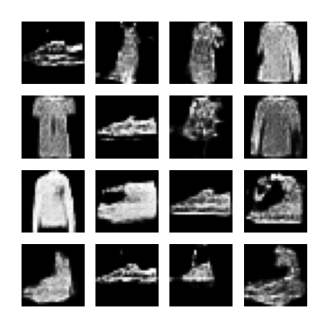

In [11]:

# Display generated images from the last epoch
last_epoch = EPOCHS
generated_image_path = f'generated_images/image_at_epoch_{last_epoch:04d}.png'
if os.path.exists(generated_image_path):
    display_img = plt.imread(generated_image_path)
    plt.figure(figsize=(4,4))
    plt.imshow(display_img)
    plt.axis('off')
    plt.show()
else:
    print(f"Generated image for epoch {last_epoch} not found.")
